# {ticker} Stock Analysis using IDX Momentum Indicator
## Indonesian Stock Market Scalping Strategy
**Based on Order Flow Analysis + Broker Action + Multi-day Accumulation**

Analysis Date: February 10, 2026

⚠️ Edit the `ticker` variable in Cell 2 to analyze any Indonesian stock

## Section 1: Import Libraries and Load Data

In [1]:
# =====================================================
# 🔧 CONFIGURATION - CHANGE TICKER HERE
# =====================================================
TICKER = "SUPA"
# =====================================================

In [2]:
import sys
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Add path to import IDXMomentumIndicator
sys.path.insert(0, '/Users/cevin/Documents/QuantResearch/docs')

# Force reload of module to pick up latest changes
if 'idx_momentum_indicator' in sys.modules:
    importlib.reload(sys.modules['idx_momentum_indicator'])

from idx_momentum_indicator import IDXMomentumIndicator

print("✓ Libraries imported successfully")
print(f"✓ IDXMomentumIndicator ready for analysis")

✓ Libraries imported successfully
✓ IDXMomentumIndicator ready for analysis


In [3]:
# Fetch historical data from yfinance using configured TICKER
ticker = TICKER
ticker_formatted = f"{ticker}.JK"

print(f"📊 Fetching {ticker} historical data...")
try:
    ppre_data = yf.download(ticker_formatted, period="max", progress=False)
    print(f"✓ Downloaded {len(ppre_data)} records")
    print(f"  Date range: {ppre_data.index.min().date()} to {ppre_data.index.max().date()}")
    
    # Display recent data
    print(f"\n📈 Recent {ticker} Price Data (Last 10 days):")
    print(ppre_data[['Close', 'Volume']].tail(10))
    
    current_price = ppre_data['Close'].iloc[-1]
    print(f"\n💰 Current Price: IDR {current_price:.0f}")
    
except Exception as e:
    print(f"⚠ Error fetching data: {e}")

📊 Fetching SUPA historical data...
✓ Downloaded 38 records
  Date range: 2025-12-17 to 2026-02-13

📈 Recent SUPA Price Data (Last 10 days):
Price        Close     Volume
Ticker     SUPA.JK    SUPA.JK
Date                         
2026-02-02   830.0  181011600
2026-02-03   895.0  418972000
2026-02-04   905.0  238339300
2026-02-05   930.0  198723600
2026-02-06   890.0  244638100
2026-02-09   935.0  216188200
2026-02-10   940.0   55527600
2026-02-11   960.0   51175300
2026-02-12   940.0   32463300
2026-02-13   955.0   34887900
⚠ Error fetching data: unsupported format string passed to Series.__format__


## Section 2: Initialize IDX Momentum Indicator

In [4]:
 # Initialize the indicator with new 6-rule system
indicator = IDXMomentumIndicator(thresholds={
    'bullish_threshold': 80,   # Confidence ≥ 80 = BULLISH (sellers dominating)
    'bearish_threshold': 20,   # Confidence ≥ 20 = BEARISH (buyers dominating)
})

print("=" * 80)
print("IDX MOMENTUM INDICATOR - 6-RULE TRADING SENTIMENT ANALYSIS")
print("=" * 80)
print(f"\n📋 Configuration:")
print(f"   System: 6-Rule Trading Sentiment Analysis")
print(f"   Total Points: 100 (max)")
print(f"   BULLISH Threshold: {indicator.thresholds['bullish_threshold']} points (sellers dominating)")
print(f"   BEARISH Threshold: {indicator.thresholds['bearish_threshold']} points (buyers dominating)")
print(f"\n   Rules:")
print(f"      1. Top 10 Summed Bid Volume vs Offer Volume (15 points)")
print(f"      2. Top Bid Volume vs Top Offer Volume (20 points)")
print(f"      3. Offer Distribution (30 points)")
print(f"      4. Top 10 Summed Bid Freq vs Offer Freq (15 points)")
print(f"      5. All Bid Volume vs All Offer Volume (10 points)")
print(f"      6. All Bid Freq vs All Offer Freq (10 points)")

print(f"\n✓ Indicator initialized and ready for {ticker} analysis")

IDX MOMENTUM INDICATOR - 6-RULE TRADING SENTIMENT ANALYSIS

📋 Configuration:
   System: 6-Rule Trading Sentiment Analysis
   Total Points: 100 (max)
   BULLISH Threshold: 80 points (sellers dominating)
   BEARISH Threshold: 20 points (buyers dominating)

   Rules:
      1. Top 10 Summed Bid Volume vs Offer Volume (15 points)
      2. Top Bid Volume vs Top Offer Volume (20 points)
      3. Offer Distribution (30 points)
      4. Top 10 Summed Bid Freq vs Offer Freq (15 points)
      5. All Bid Volume vs All Offer Volume (10 points)
      6. All Bid Freq vs All Offer Freq (10 points)

✓ Indicator initialized and ready for SUPA analysis


## Section 3: Fetch Live Order Book from API

**Real-time Market Microstructure Data:**
- Bid prices/volumes/frequencies: **LIVE from datasaham.io API**
- Ask prices/volumes/frequencies: **LIVE from datasaham.io API**
- HAKA volume: Foreign aggressive buy volume (from API)
- HAKI volume: Foreign aggressive sell volume (from API)
- Net flow data: 3-day broker flow summary (from API)

→ All data is **REAL TIME** fetched directly from `/api/emiten/{SYMBOL}/orderbook`

In [5]:
# FETCH ORDER BOOK FROM LIVE API
import requests

api_key = "sbk_b0df044971dab991ddb075caf87b8df83ad0fbd2d67d3a92"
base_url = "https://api.datasaham.io/api/emiten"

def fetch_live_orderbook(symbol):
    """Fetch real order book from API"""
    url = f"{base_url}/{symbol}/orderbook"
    headers = {'x-api-key': api_key}
    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        return response.json()
    except Exception as e:
        print(f"Error: {e}")
        return None

# Fetch order book from API
print(f"🔄 Fetching {ticker} order book from datasaham.io API...")
api_data = fetch_live_orderbook(ticker)

if api_data and api_data.get('success'):
    ob = api_data['data']
    
    # Extract BID data from API (convert from shares to lots: 1 lot = 100 shares)
    bid_prices = [int(b['price']) for b in ob['bid'][:10]]
    bid_volumes = [int(b['volume']) / 100 for b in ob['bid'][:10]]
    bid_freqs = [int(b['que_num']) for b in ob['bid'][:10]]
    
    # Extract ASK/OFFER data from API (convert from shares to lots: 1 lot = 100 shares)
    ask_prices = [int(a['price']) for a in ob['offer'][:10]]
    ask_volumes = [int(a['volume']) / 100 for a in ob['offer'][:10]]
    ask_freqs = [int(a['que_num']) for a in ob['offer'][:10]]
    
    # Calculate totals from ALL levels in order book (Rules 5 & 6)
    all_bid_volumes = [int(b['volume']) / 100 for b in ob['bid']]  # ALL bid levels
    all_ask_volumes = [int(a['volume']) / 100 for a in ob['offer']]  # ALL ask levels
    all_bid_freqs = [int(b['que_num']) for b in ob['bid']]  # ALL bid frequencies
    all_ask_freqs = [int(a['que_num']) for a in ob['offer']]  # ALL ask frequencies
    
    total_bid_volume = sum(all_bid_volumes)  # Sum of ALL bid volumes
    total_ask_volume = sum(all_ask_volumes)  # Sum of ALL ask volumes
    total_bid_freq = sum(all_bid_freqs)  # Sum of ALL bid frequencies
    total_ask_freq = sum(all_ask_freqs)  # Sum of ALL ask frequencies
    
    # Extract broker activity from API (convert from shares to lots)
    current_price = int(ob['lastprice'])
    bid_ask_spread = ask_prices[0] - bid_prices[0]
    haka_volume = int(ob['fbuy']) / 100  # Foreign aggressive buy (in lots)
    haki_volume = int(ob['fsell']) / 100  # Foreign aggressive sell (in lots)
    fnet = int(ob['fnet']) / 100  # Foreign net flow (in lots)
    
    print(f"✅ Live data loaded: {ob['name']} ({ob['symbol']})")
else:
    print("❌ Failed to fetch API data - using fallback simulated data")
    bid_prices = [280, 279, 278, 277, 276]
    bid_volumes = [4500, 3800, 5200, 2800, 3400]  # in lots
    bid_freqs = [120, 95, 110, 78, 65]
    ask_prices = [281, 282, 283, 284, 285]
    ask_volumes = [5500, 4200, 4800, 3500, 4000]  # in lots
    ask_freqs = [130, 105, 98, 85, 75]
    current_price = 280
    bid_ask_spread = 1
    haka_volume = 650  # in lots
    haki_volume = 550  # in lots
    fnet = 100  # in lots
    total_bid_volume = sum(bid_volumes)
    total_ask_volume = sum(ask_volumes)
    total_bid_freq = sum(bid_freqs)
    total_ask_freq = sum(ask_freqs)

# Calculate 3-day net flow (using current fnet as proxy for recent trend)
net_flow_3days = [fnet / 1e6, fnet / 1e6 * 0.8, fnet / 1e6 * 0.6]

# Create order book summary
print("=" * 80)
print(f"{ticker} ORDER BOOK SNAPSHOT - Current Microstructure (in LOTS)")
print("=" * 80)

# Create DataFrame for better visualization
bid_df = pd.DataFrame({
    'Level': range(1, 11),
    'Bid Price': bid_prices,
    'Bid Volume (Lots)': [f"{int(v):,}" for v in bid_volumes],
    'Bid Freq': bid_freqs
})

ask_df = pd.DataFrame({
    'Level': range(1, 11),
    'Ask Price': ask_prices,
    'Ask Volume (Lots)': [f"{int(v):,}" for v in ask_volumes],
    'Ask Freq': ask_freqs
})

print("\n📊 BID SIDE (Buyers):")
print(bid_df.to_string(index=False))

print("\n\n📊 ASK SIDE (Sellers):")
print(ask_df.to_string(index=False))

print(f"\n💰 Market Info:")
print(f"   Current Price: IDR {current_price}")
print(f"   Bid-Ask Spread: {bid_ask_spread} IDR ({(bid_ask_spread/current_price)*100:.2f}%)")
print(f"   Total Bid Volume: {int(total_bid_volume):,} lots")
print(f"   Total Ask Volume: {int(total_ask_volume):,} lots")
print(f"   Volume Ratio (Ask/Bid): {total_ask_volume/total_bid_volume:.2f}x")

print(f"\n🔥 Aggressive Volume:")
print(f"   HAKA (Aggressive Buy): {int(haka_volume):,} lots")
print(f"   HAKI (Aggressive Sell): {int(haki_volume):,} lots")
print(f"   Net Aggressive: {'BUY' if haka_volume > haki_volume else 'SELL'}")

print(f"\n📈 Broker 3-Day Net Flow: {net_flow_3days} (Millions IDR)")


🔄 Fetching SUPA order book from datasaham.io API...
✅ Live data loaded: Super Bank Indonesia Tbk. (SUPA)
SUPA ORDER BOOK SNAPSHOT - Current Microstructure (in LOTS)

📊 BID SIDE (Buyers):
 Level  Bid Price Bid Volume (Lots)  Bid Freq
     1        955             3,949        29
     2        950            11,438        82
     3        945             6,482        65
     4        940            14,433       163
     5        935            16,581       128
     6        930            27,102       312
     7        925            11,680       151
     8        920            14,227       153
     9        915            14,094        82
    10        910             5,637        83


📊 ASK SIDE (Sellers):
 Level  Ask Price Ask Volume (Lots)  Ask Freq
     1        960             2,285        21
     2        965             7,253       107
     3        970            12,262       106
     4        975             9,736        92
     5        980            13,984        92
     6 

In [6]:
# Perform Trading Sentiment Analysis using 6-Rule System (Dual Direction)
sentiment_result = indicator.analyze_sentiment(
    bid_prices=bid_prices,
    bid_volumes=bid_volumes,
    bid_freqs=bid_freqs,
    offer_prices=ask_prices,
    offer_volumes=ask_volumes,
    offer_freqs=ask_freqs
)

print("=" * 80)
print(f"TRADING SENTIMENT ANALYSIS (6-RULE SYSTEM - DUAL DIRECTION) - {ticker}")
print("=" * 80)

# Display both confidence scores
print(f"\n📊 CONFIDENCE SCORES:")
print(f"   🟢 BULLISH Score (Sellers dominating): {sentiment_result['bullish_confidence']}/100")
print(f"   🔴 BEARISH Score (Buyers dominating):  {sentiment_result['bearish_confidence']}/100")

print(f"\n🎯 FINAL SIGNAL: {sentiment_result['summary']['signal']}")
print(f"📍 Sentiment Category: {sentiment_result['sentiment']}")

print(f"\n{'=' * 80}")

# Show rules passed based on sentiment
if sentiment_result['sentiment'] == 'BULLISH':
    print("BULLISH RULES PASSED (Sellers Dominating):")
    rules_to_show = sentiment_result['all_rules']['bullish']
elif sentiment_result['sentiment'] == 'BEARISH':
    print("BEARISH RULES PASSED (Buyers Dominating):")
    rules_to_show = sentiment_result['all_rules']['bearish']
else:
    print("NEUTRAL - NO CLEAR DOMINANCE (Mixed Signals):")
    print(f"   Bullish: {sentiment_result['bullish_confidence']}/100")
    print(f"   Bearish: {sentiment_result['bearish_confidence']}/100")
    rules_to_show = sentiment_result['all_rules']['bullish']

print("=" * 80)

total_passed = 0
for rule_key, rule_data in rules_to_show.items():
    if rule_data['passed']:
        total_passed += 1
        print(f"✓ {rule_key} ({rule_data['points']} pts): {rule_data['name']}")

print(f"\n{'─' * 80}")
print(f"TOTAL: {total_passed}/6 rules passed | {sentiment_result['confidence']}/100 points")
print(f"{'=' * 80}")

# Signal interpretation
print(f"\n📊 SIGNAL INTERPRETATION:")
if sentiment_result['sentiment'] == 'BULLISH':
    if sentiment_result['confidence'] >= 90:
        print(f"🚀 VERY STRONG BULLISH - Sellers massively dominating")
        print(f"   Action: AGGRESSIVE BUY")
    elif sentiment_result['confidence'] >= 85:
        print(f"🟢 STRONG BULLISH - Strong seller pressure")
        print(f"   Action: GOOD BUY opportunity")
    elif sentiment_result['confidence'] >= 80:
        print(f"🟢 BULLISH - Buy signal detected")
        print(f"   Action: WAIT for confirmation")
elif sentiment_result['sentiment'] == 'BEARISH':
    if sentiment_result['confidence'] >= 90:
        print(f"🔴 VERY STRONG BEARISH - Buyers massively dominating")
        print(f"   Action: IMMEDIATE EXIT")
    elif sentiment_result['confidence'] >= 85:
        print(f"🔴 STRONG BEARISH - Strong buyer pressure")
        print(f"   Action: CLOSE POSITION")
    else:
        print(f"⚫ BEARISH - Avoid entries, buyers strong")
        print(f"   Action: CAUTION")
else:
    print(f"⚪ NEUTRAL - Balanced market, neither side dominant")
    print(f"   Action: WAIT for clearer signal")

print("=" * 80)


TRADING SENTIMENT ANALYSIS (6-RULE SYSTEM - DUAL DIRECTION) - SUPA

📊 CONFIDENCE SCORES:
   🟢 BULLISH Score (Sellers dominating): 0/100
   🔴 BEARISH Score (Buyers dominating):  50/100

🎯 FINAL SIGNAL: ⬇️ BEARISH (Confidence: 50/100)
📍 Sentiment Category: BEARISH

BEARISH RULES PASSED (Buyers Dominating):
✓ rule_1 (15 pts): Top 10 Summed Offer Volume vs Bid Volume
✓ rule_4 (15 pts): Top 10 Summed Offer Freq vs Bid Freq
✓ rule_5 (10 pts): All Offer Volume vs All Bid Volume
✓ rule_6 (10 pts): All Offer Freq vs All Bid Freq

────────────────────────────────────────────────────────────────────────────────
TOTAL: 4/6 rules passed | 50/100 points

📊 SIGNAL INTERPRETATION:
⚫ BEARISH - Avoid entries, buyers strong
   Action: CAUTION


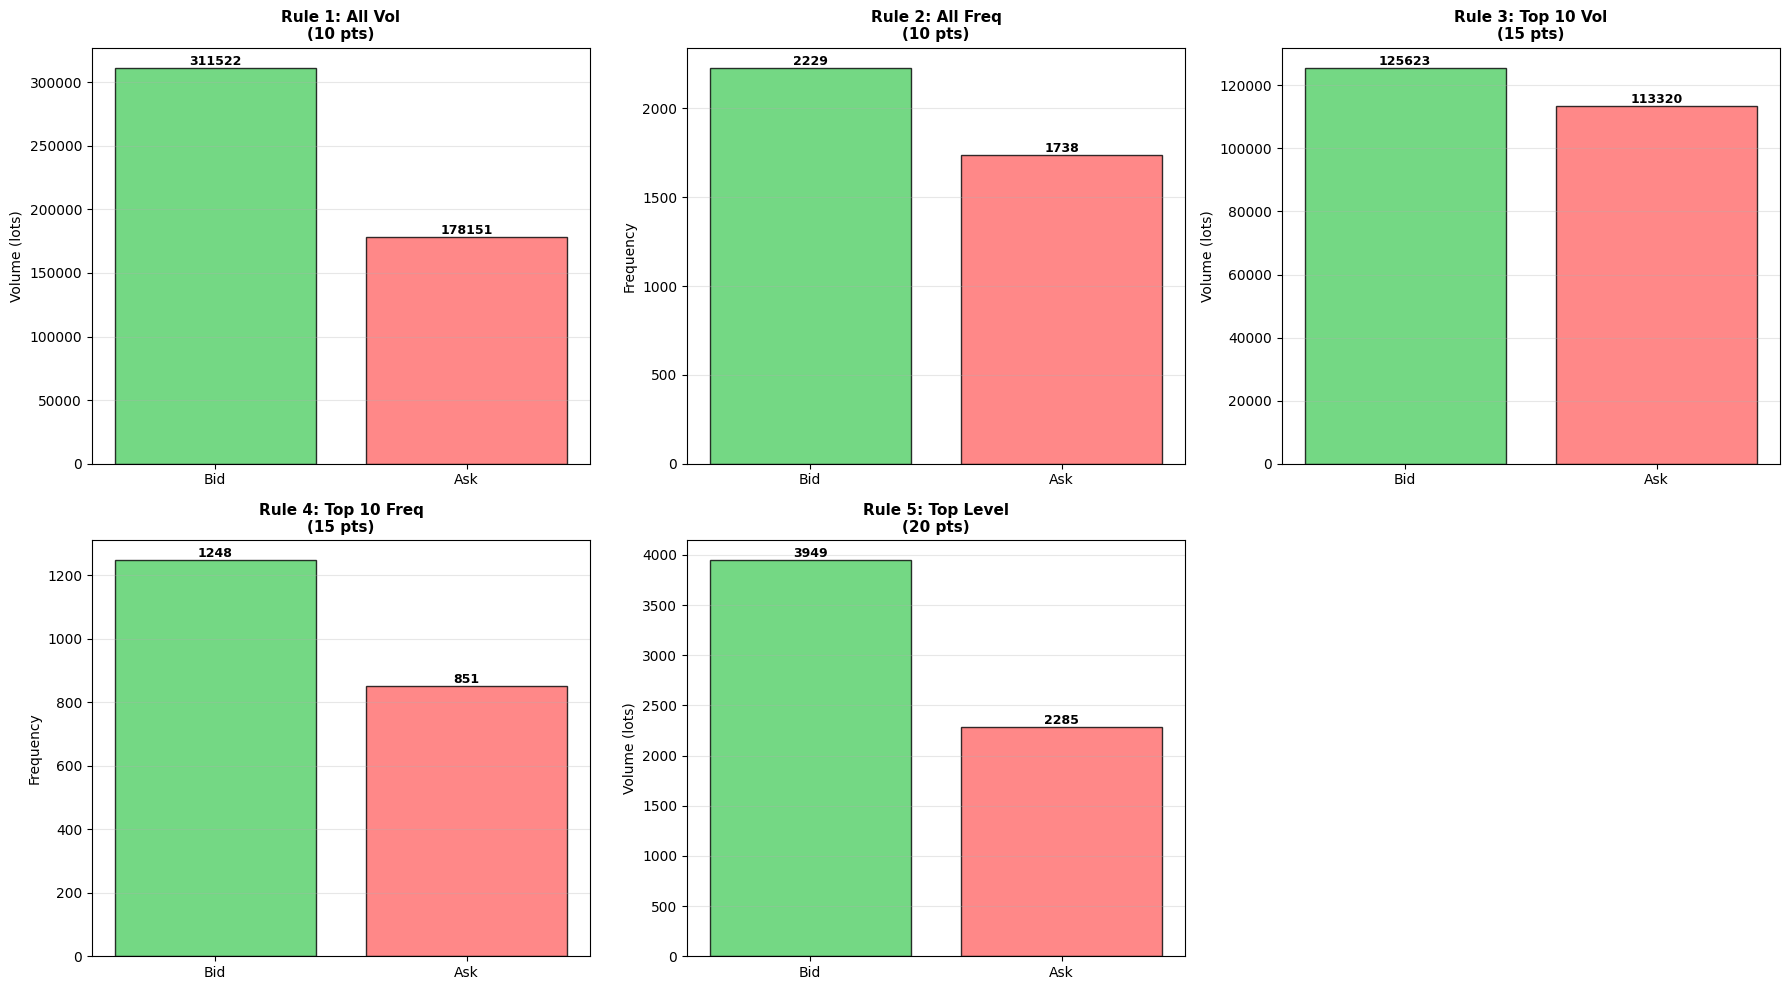

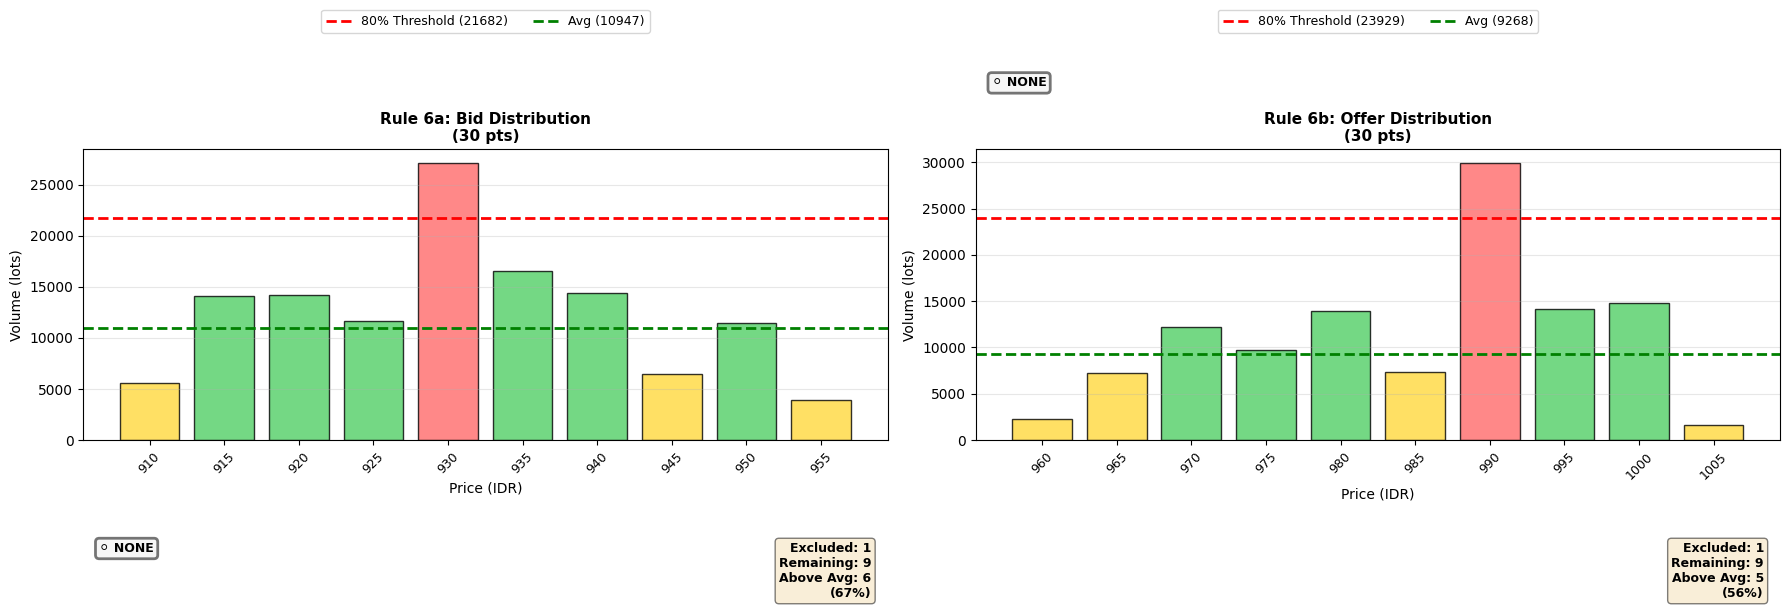


FINAL ANALYSIS SUMMARY - SUPA USING IDX MOMENTUM INDICATOR

🎯 IDX MOMENTUM INDICATOR - SENTIMENT ANALYSIS:
   Bullish Confidence: 0/100
   Bearish Confidence: 50/100

📈 DOMINANT SIGNAL: BEARISH
   Overall Confidence: 50/100
⚫ BEARISH - Avoid entries, buyers strong

📋 RULES RECAP:
   1. Top 10 Summed Bid Volume vs Offer Volume - 🔴 BEAR
   2. Top Bid Volume vs Top Offer Volume - ⚪ NEUTRAL
   3. Distribusi Offer Volume - Kerapian Tick - ⚪ NEUTRAL
   4. Top 10 Summed Bid Freq vs Offer Freq - 🔴 BEAR
   5. All Bid Volume vs All Offer Volume - 🔴 BEAR
   6. All Bid Freq vs All Offer Freq - 🔴 BEAR



In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Extract bullish and bearish rules from sentiment result
bullish_rules = sentiment_result['all_rules']['bullish']
bearish_rules = sentiment_result['all_rules']['bearish']

# Define helper function for status badges
def add_rule_status(ax, rule_num):
    """Add rule status badge to subplot"""
    pass

# Window 1: Figure 1 - 2x3 Grid for Rules 1-5
fig1, axes1 = plt.subplots(2, 3, figsize=(18, 10))

# Rule 1 (All Volume)
ax = axes1[0, 0]
bars1 = ax.bar(['Bid', 'Ask'], [total_bid_volume, total_ask_volume], 
               color=['#51cf66' if total_bid_volume > total_ask_volume else '#ff6b6b',
                      '#ff6b6b' if total_bid_volume > total_ask_volume else '#51cf66'],
               alpha=0.8, edgecolor='black', linewidth=1)
ax.set_title('Rule 1: All Vol\n(10 pts)', fontweight='bold', fontsize=11)
ax.set_ylabel('Volume (lots)')
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=9)
ax.grid(axis='y', alpha=0.3)
rule_key = 'rule_1'
bullish_pass = bullish_rules.get(rule_key, {}).get('passed', False)
bearish_pass = bearish_rules.get(rule_key, {}).get('passed', False)
add_rule_status(ax, 1)

# Rule 2 (All Frequency)
ax = axes1[0, 1]
bars2 = ax.bar(['Bid', 'Ask'], [total_bid_freq, total_ask_freq],
               color=['#51cf66' if total_bid_freq > total_ask_freq else '#ff6b6b',
                      '#ff6b6b' if total_bid_freq > total_ask_freq else '#51cf66'],
               alpha=0.8, edgecolor='black', linewidth=1)
ax.set_title('Rule 2: All Freq\n(10 pts)', fontweight='bold', fontsize=11)
ax.set_ylabel('Frequency')
for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=9)
ax.grid(axis='y', alpha=0.3)
rule_key = 'rule_2'
bullish_pass = bullish_rules.get(rule_key, {}).get('passed', False)
bearish_pass = bearish_rules.get(rule_key, {}).get('passed', False)
add_rule_status(ax, 2)

# Rule 3 (Top 10 Volume)
ax = axes1[0, 2]
top10_bid = sum(sorted(bid_volumes, reverse=True)[:10])
top10_ask = sum(sorted(ask_volumes, reverse=True)[:10])
bars4 = ax.bar(['Bid', 'Ask'], [top10_bid, top10_ask],
               color=['#51cf66' if top10_bid > top10_ask else '#ff6b6b',
                      '#ff6b6b' if top10_bid > top10_ask else '#51cf66'],
               alpha=0.8, edgecolor='black', linewidth=1)
ax.set_title('Rule 3: Top 10 Vol\n(15 pts)', fontweight='bold', fontsize=11)
ax.set_ylabel('Volume (lots)')
for bar in bars4:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=9)
ax.grid(axis='y', alpha=0.3)
rule_key = 'rule_3'
bullish_pass = bullish_rules.get(rule_key, {}).get('passed', False)
bearish_pass = bearish_rules.get(rule_key, {}).get('passed', False)
add_rule_status(ax, 3)

# Rule 4 (Top 10 Frequency)
ax = axes1[1, 0]
top10_bid_freq = sum(sorted(bid_freqs, reverse=True)[:10])
top10_ask_freq = sum(sorted(ask_freqs, reverse=True)[:10])
bars5 = ax.bar(['Bid', 'Ask'], [top10_bid_freq, top10_ask_freq],
               color=['#51cf66' if top10_bid_freq > top10_ask_freq else '#ff6b6b',
                      '#ff6b6b' if top10_bid_freq > top10_ask_freq else '#51cf66'],
               alpha=0.8, edgecolor='black', linewidth=1)
ax.set_title('Rule 4: Top 10 Freq\n(15 pts)', fontweight='bold', fontsize=11)
ax.set_ylabel('Frequency')
for bar in bars5:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=9)
ax.grid(axis='y', alpha=0.3)
rule_key = 'rule_4'
bullish_pass = bullish_rules.get(rule_key, {}).get('passed', False)
bearish_pass = bearish_rules.get(rule_key, {}).get('passed', False)
add_rule_status(ax, 4)

# Rule 5 (Top Level Volume)
ax = axes1[1, 1]
rule5_bid = bid_volumes[0] if bid_volumes else 0
rule5_ask = ask_volumes[0] if ask_volumes else 0
bars6 = ax.bar(['Bid', 'Ask'], [rule5_bid, rule5_ask],
               color=['#51cf66' if rule5_bid > rule5_ask else '#ff6b6b',
                      '#ff6b6b' if rule5_bid > rule5_ask else '#51cf66'],
               alpha=0.8, edgecolor='black', linewidth=1)
ax.set_title('Rule 5: Top Level\n(20 pts)', fontweight='bold', fontsize=11)
ax.set_ylabel('Volume (lots)')
for bar in bars6:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=9)
ax.grid(axis='y', alpha=0.3)
rule_key = 'rule_5'
bullish_pass = bullish_rules.get(rule_key, {}).get('passed', False)
bearish_pass = bearish_rules.get(rule_key, {}).get('passed', False)
add_rule_status(ax, 5)

# Empty subplot
axes1[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Window 2: Figure 2 - 1x2 Grid for Rule 6 (Bid & Offer Distribution)
fig2, axes2 = plt.subplots(1, 2, figsize=(18, 7))
fig2.subplots_adjust(top=0.85)

# Rule 6a: Bid Distribution (Mirrored/Reversed)
ax = axes2[0]

# Reverse bid volumes and prices for mirrored display
bid_volumes_reversed = bid_volumes[::-1]
bid_prices_reversed = bid_prices[::-1]

top_val_bid = max(bid_volumes) if bid_volumes else 0
threshold_80pct_bid = top_val_bid * 0.8
excluded_vals_bid = [v for v in bid_volumes if v > threshold_80pct_bid]
remaining_vals_bid = [v for v in bid_volumes if v <= threshold_80pct_bid]

if len(remaining_vals_bid) > 0:
    avg_remaining_bid = np.mean(remaining_vals_bid)
    pct_above_avg_bid = (len([v for v in remaining_vals_bid if v > avg_remaining_bid]) / len(remaining_vals_bid)) * 100
    above_avg_bid = len([v for v in remaining_vals_bid if v > avg_remaining_bid])
else:
    avg_remaining_bid = 0
    pct_above_avg_bid = 0
    above_avg_bid = 0

# Reverse bid volumes and prices for mirrored display
bid_volumes_reversed = bid_volumes[::-1]
bid_prices_reversed = bid_prices[::-1]

colors_bid_dist = []
for v in bid_volumes_reversed:
    if v > threshold_80pct_bid:
        colors_bid_dist.append('#ff6b6b')
    elif v > avg_remaining_bid:
        colors_bid_dist.append('#51cf66')
    else:
        colors_bid_dist.append('#ffd93d')

bars_bid_dist = ax.bar(range(len(bid_volumes_reversed)), bid_volumes_reversed, color=colors_bid_dist, alpha=0.8, edgecolor='black', linewidth=1)
ax.axhline(y=threshold_80pct_bid, color='red', linestyle='--', linewidth=2, label=f'80% Threshold ({threshold_80pct_bid:.0f})')
ax.axhline(y=avg_remaining_bid, color='green', linestyle='--', linewidth=2, label=f'Avg ({avg_remaining_bid:.0f})')

ax.set_title('Rule 6a: Bid Distribution\n(30 pts)', fontweight='bold', fontsize=11)
ax.set_ylabel('Volume (lots)')
ax.set_xlabel('Price (IDR)')
ax.set_xticks(range(len(bid_prices_reversed)))
ax.set_xticklabels([f'{int(p)}' for p in bid_prices_reversed], fontsize=9, rotation=45)
ax.legend(fontsize=9, loc='upper center', bbox_to_anchor=(0.5, 1.50), ncol=2)
ax.grid(axis='y', alpha=0.3)

# Status indicator at top left
rule_key = 'rule_3'
bullish_pass = bullish_rules.get(rule_key, {}).get('passed', False)
bearish_pass = bearish_rules.get(rule_key, {}).get('passed', False)
status_text = ""
bg_color = 'white'
edge_color = 'black'
if bullish_pass and bearish_pass:
    status_text = "🟢 BULL | 🔴 BEAR"
    bg_color = '#e8f5e9'
    edge_color = '#2ca02c'
elif bullish_pass:
    status_text = "🟢 BULL"
    bg_color = '#e8f5e9'
    edge_color = '#2ca02c'
elif bearish_pass:
    status_text = "🔴 BEAR"
    bg_color = '#ffebee'
    edge_color = '#d62728'
else:
    status_text = "⚪ NONE"
    bg_color = '#f5f5f5'
    edge_color = '#666666'
ax.text(0.02, -0.35, status_text, transform=ax.transAxes, fontsize=9, 
        verticalalignment='top', horizontalalignment='left', 
        bbox=dict(boxstyle='round', facecolor=bg_color, alpha=0.9, edgecolor=edge_color, linewidth=2),
        fontweight='bold')

# Summary text at bottom right
summary_text_bid = f"Excluded: {len(excluded_vals_bid)}\nRemaining: {len(remaining_vals_bid)}\nAbove Avg: {above_avg_bid}\n({pct_above_avg_bid:.0f}%)"
ax.text(0.98, -0.35, summary_text_bid, transform=ax.transAxes, fontsize=9, verticalalignment='top', 
         horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontweight='bold')

# Rule 6b: Offer Distribution
ax = axes2[1]

top_val_offer = max(ask_volumes) if ask_volumes else 0
threshold_80pct_offer = top_val_offer * 0.8
excluded_vals_offer = [v for v in ask_volumes if v > threshold_80pct_offer]
remaining_vals_offer = [v for v in ask_volumes if v <= threshold_80pct_offer]

if len(remaining_vals_offer) > 0:
    avg_remaining_offer = np.mean(remaining_vals_offer)
    pct_above_avg_offer = (len([v for v in remaining_vals_offer if v > avg_remaining_offer]) / len(remaining_vals_offer)) * 100
    above_avg_offer = len([v for v in remaining_vals_offer if v > avg_remaining_offer])
else:
    avg_remaining_offer = 0
    pct_above_avg_offer = 0
    above_avg_offer = 0

colors_offer_dist = []
for v in ask_volumes:
    if v > threshold_80pct_offer:
        colors_offer_dist.append('#ff6b6b')
    elif v > avg_remaining_offer:
        colors_offer_dist.append('#51cf66')
    else:
        colors_offer_dist.append('#ffd93d')

bars_offer_dist = ax.bar(range(len(ask_volumes)), ask_volumes, color=colors_offer_dist, alpha=0.8, edgecolor='black', linewidth=1)
ax.axhline(y=threshold_80pct_offer, color='red', linestyle='--', linewidth=2, label=f'80% Threshold ({threshold_80pct_offer:.0f})')
ax.axhline(y=avg_remaining_offer, color='green', linestyle='--', linewidth=2, label=f'Avg ({avg_remaining_offer:.0f})')

ax.set_title('Rule 6b: Offer Distribution\n(30 pts)', fontweight='bold', fontsize=11)
ax.set_ylabel('Volume (lots)')
ax.set_xlabel('Price (IDR)')
ax.set_xticks(range(len(ask_prices)))
ax.set_xticklabels([f'{int(p)}' for p in ask_prices], fontsize=9, rotation=45)
ax.legend(fontsize=9, loc='upper center', bbox_to_anchor=(0.5, 1.50), ncol=2)
ax.grid(axis='y', alpha=0.3)

# Status indicator at top left (same as 6a)
rule_key = 'rule_3'
bullish_pass = bullish_rules.get(rule_key, {}).get('passed', False)
bearish_pass = bearish_rules.get(rule_key, {}).get('passed', False)
status_text = ""
bg_color = 'white'
edge_color = 'black'
if bullish_pass and bearish_pass:
    status_text = "🟢 BULL | 🔴 BEAR"
    bg_color = '#e8f5e9'
    edge_color = '#2ca02c'
elif bullish_pass:
    status_text = "🟢 BULL"
    bg_color = '#e8f5e9'
    edge_color = '#2ca02c'
elif bearish_pass:
    status_text = "🔴 BEAR"
    bg_color = '#ffebee'
    edge_color = '#d62728'
else:
    status_text = "⚪ NONE"
    bg_color = '#f5f5f5'
    edge_color = '#666666'
ax.text(0.02, 1.25, status_text, transform=ax.transAxes, fontsize=9, 
        verticalalignment='top', horizontalalignment='left', 
        bbox=dict(boxstyle='round', facecolor=bg_color, alpha=0.9, edgecolor=edge_color, linewidth=2),
        fontweight='bold')

summary_text_offer = f"Excluded: {len(excluded_vals_offer)}\nRemaining: {len(remaining_vals_offer)}\nAbove Avg: {above_avg_offer}\n({pct_above_avg_offer:.0f}%)"
ax.text(0.98, -0.35, summary_text_offer, transform=ax.transAxes, fontsize=9, verticalalignment='top', 
         horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontweight='bold')

fig2.subplots_adjust(bottom=0.30)
plt.tight_layout()
plt.show()

# Print Summary Report
print("\n" + "=" * 80)
print(f"FINAL ANALYSIS SUMMARY - {ticker} USING IDX MOMENTUM INDICATOR")
print("=" * 80)

print(f"\n🎯 IDX MOMENTUM INDICATOR - SENTIMENT ANALYSIS:")
print(f"   Bullish Confidence: {sentiment_result['bullish_confidence']}/100")
print(f"   Bearish Confidence: {sentiment_result['bearish_confidence']}/100")

print(f"\n📈 DOMINANT SIGNAL: {sentiment_result['sentiment']}")
print(f"   Overall Confidence: {sentiment_result['confidence']}/100")

if sentiment_result['sentiment'] == 'BULLISH':
    if sentiment_result['confidence'] >= 90:
        print(f"🟢 VERY STRONG BULLISH - Sellers massively dominating")
        print(f"   Action: GOOD BUY opportunity")
    elif sentiment_result['confidence'] >= 80:
        print(f"🟢 BULLISH - Buy signal detected")
        print(f"   Action: WAIT for confirmation")
elif sentiment_result['sentiment'] == 'BEARISH':
    if sentiment_result['confidence'] >= 90:
        print(f"🔴 VERY STRONG BEARISH - Buyers massively dominating")
        print(f"   Action: IMMEDIATE EXIT")
    elif sentiment_result['confidence'] >= 85:
        print(f"🔴 STRONG BEARISH - Strong buyer pressure")
        print(f"   Action: CLOSE POSITION")
    else:
        print(f"⚫ BEARISH - Avoid entries, buyers strong")
else:
    print(f"⚪ NEUTRAL - Mixed signals, no clear direction")

print(f"\n📋 RULES RECAP:")
# Get all unique rule keys from both bullish and bearish
all_rule_keys = set(sentiment_result['all_rules']['bullish'].keys()) | set(sentiment_result['all_rules']['bearish'].keys())

for i, rule_key in enumerate(sorted(all_rule_keys), 1):
    bullish_data = sentiment_result['all_rules']['bullish'].get(rule_key, {})
    bearish_data = sentiment_result['all_rules']['bearish'].get(rule_key, {})
    
    bullish_pass = bullish_data.get('passed', False)
    bearish_pass = bearish_data.get('passed', False)
    
    # Get rule name from whichever dictionary has it
    rule_name = bullish_data.get('name') or bearish_data.get('name', 'Unknown Rule')
    
    if bullish_pass:
        status = "🟢 BULL"
    elif bearish_pass:
        status = "🔴 BEAR"
    else:
        status = "⚪ NEUTRAL"
    
    print(f"   {i}. {rule_name} - {status}")

print("\n" + "=" * 80)